In [1]:
import json
import pandas as pd
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

# plotting config
textwidth_pt = 395.8225
table_cell_width_pt = textwidth_pt/8

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # ACM uses Linux Libertine as the main font
    "text.latex.preamble": r"\usepackage{libertine}",
    # Use 9pt font in plots to match ACM style
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts slightly smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
plt.rcParams.update(tex_fonts)
sns.set_palette("deep")

In [3]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def read_csv_dataset(dataset_path):
    """
    This method reads a dataset from a csv file path.
    """
    dataframe = pd.read_csv(dataset_path, sep=",", header="infer", encoding="utf-8", dtype=str,
                                keep_default_na=False, low_memory=False)
    return dataframe

In [4]:
def get_measurements(measurements_dir: str = 'measurements/'):
    measurements = []
    pathlist = Path(measurements_dir).glob('*.json')
    
    for path in pathlist:
        with open(path) as f:
            res = json.load(f)
            run, dataset = path.name.split('.')[0].split('-')
            res = {'run': run, 'dataset': dataset, **res}
            measurements.append(res)
    
    print(f'{len(measurements)} measurements loaded.')
    return measurements

In [7]:
results = get_measurements('measurements/20241031-hospital-replica/')
df = pd.DataFrame(results)

50 measurements loaded.


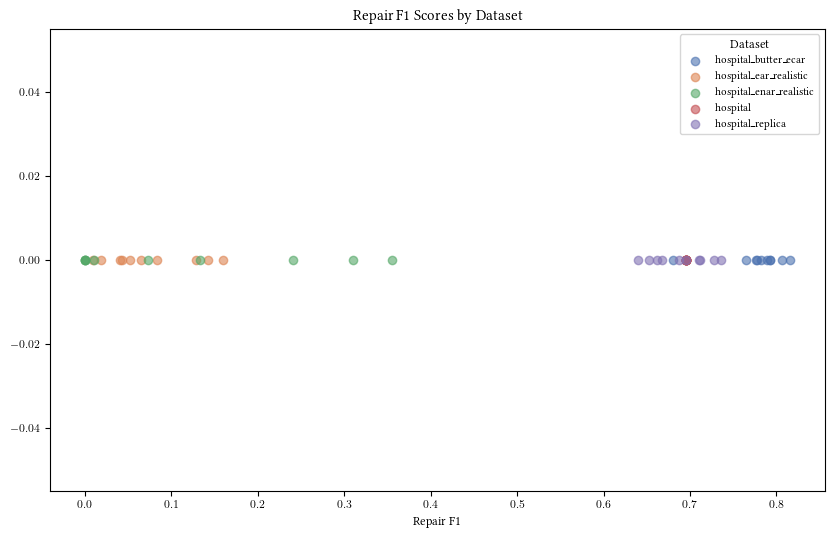

In [8]:
plt.figure(figsize=(10, 6))

# Use unique dataset values to loop and plot each with a different color
for dataset_name in df['dataset'].unique():
    subset = df[df['dataset'] == dataset_name]
    plt.scatter(subset['repair_f1'], [0] * len(subset), label=dataset_name, alpha=0.6)

# Add labels and title
plt.xlabel('Repair F1')
plt.title('Repair F1 Scores by Dataset')
plt.legend(title='Dataset')

# Show plot
plt.show()

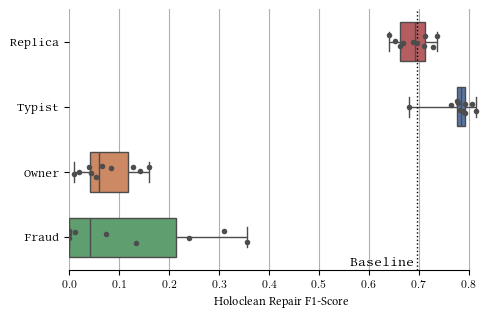

In [9]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe and relabel the datasets with LaTeX-style formatting
df_sub = df[df['dataset'].isin(['hospital_replica', 'hospital_butter_ecar', 'hospital_ear_realistic', 'hospital_enar_realistic'])]
df_sub.loc[:, 'dataset'] = df_sub['dataset'].replace(
    ['hospital_butter_ecar', 'hospital_replica', 'hospital_ear_realistic', 'hospital_enar_realistic'],
    [r'\texttt{Typist}', r'\texttt{Replica}', r'\texttt{Owner}', r'\texttt{Fraud}']
)

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=set_size(textwidth_pt))
ax.set_xlim(0, .85)

# Plot the orbital period with horizontal boxes
sns.boxplot(
    df_sub, 
    x="repair_f1", 
    y="dataset", 
    hue="dataset",
    whis=[0, 100], 
    width=.6, 
    order=[r'\texttt{Replica}', r'\texttt{Typist}', r'\texttt{Owner}', r'\texttt{Fraud}']
)

# Add in points to show each observation
sns.stripplot(df_sub, x="repair_f1", y="dataset", size=4, color=".3")

# Add reference to hospital baseline
hosp_baseline = df[df['dataset'] == 'hospital'].repair_f1.iloc[0]
ax.axvline(x=hosp_baseline, color='black', linestyle=':', linewidth=1)
ax.text(hosp_baseline - 0.005, (1-0.06)*ax.get_ylim()[0], r'\texttt{Baseline}', color='black', 
        ha='right', va='top', rotation=0, fontsize=9, fontweight='bold')

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="Holoclean Repair F1-Score")
sns.despine(trim=True, left=True)
plt.savefig("img/2024-11-19-hosp-error-scenarios.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Error-Histograms

In [26]:
mechanisms = ['ECAR', 'EAR', 'ENAR']
default_palette = sns.color_palette()  # This gives the default Seaborn palette
palette_dict = {'ECAR': default_palette[0], 'EAR': default_palette[1], 'ENAR': default_palette[5]}

### Original

In [10]:
df_clean_str = read_csv_dataset('../data/hospital/clean.csv').astype(str)
df_dirty_str = read_csv_dataset('../data/hospital/dirty.csv').astype(str)
df_clean_str = df_clean_str.rename(columns={'StateAverage': 'Stateavg'})
df_dirty_str = df_dirty_str.rename(columns={'StateAverage': 'Stateavg'})
df_clean_str = df_clean_str.drop('index', axis=1)
df_dirty_str = df_dirty_str.drop('index', axis=1)

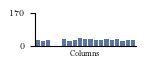

In [12]:
se_errors = (df_clean_str != df_dirty_str).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 'ECAR'
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
#plt.savefig("img/2024-11-12-hosp-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

### EAR Realistic

In [13]:
df_realistic_clean = read_csv_dataset('../export_data/hospital/hospital_ear_realistic_clean.csv')
df_realistic_dirty = read_csv_dataset('../export_data/hospital/hospital_ear_realistic_0.csv')

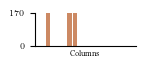

In [14]:
se_errors = (df_realistic_clean != df_realistic_dirty).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 'EAR'
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
plt.savefig("img/2024-11-12-hosp-realistic-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## ENAR Realistic

In [23]:
df_enar_realistic_clean = read_csv_dataset('../export_data/hospital/hospital_enar_realistic_clean.csv')
df_enar_realistic_dirty = read_csv_dataset('../export_data/hospital/hospital_enar_realistic_0.csv')

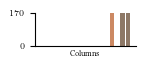

In [34]:
se_errors = (df_enar_realistic_clean != df_enar_realistic_dirty).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 16*['EAR'] + 3*['ENAR']
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
plt.savefig("img/2024-11-18-hosp-enar-realistic-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

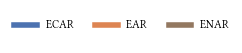

In [15]:
# Create a figure and axis with no data
fig, ax = plt.subplots(figsize=(1.3, 0.43))

# Create legend handles manually
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in palette_dict.values()]

# Add the legend to the figure
legend = ax.legend(handles, list(palette_dict.keys()), loc="center", frameon=False, ncol=len(palette_dict))

# Remove axis from the figure to leave only the legend
ax.axis("off")

# Adjust figure size so it fits the legend only
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("img/2024-11-12-legend-histogram.pdf", bbox_inches=bbox, format="pdf")
plt.show()